In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
import itertools
import json
import numpy as np
from pylhe import read_lhe_with_attributes, read_num_events
import itertools
import json
import math
import vector
import mplhep as hep
from scipy.optimize import curve_fit
import os
import pandas as pd

## Functions

## Importing data

In [2]:
import json

# Path to the combined JSON file
combined_file_path = r"..\..\DataFiles\combined_data.json"

# Read the JSON file
with open(combined_file_path, 'r') as file:
    data = json.load(file) 



In [3]:
print("Keys in the JSON data:", data.keys())

Keys in the JSON data: dict_keys(['100.0', '13.0', '13.6', '14.0', '20.0', '50.0', '70.0'])


In [4]:
# Inspect the nested structure of the data
for key, value in data.items():
    print(f"Key: {key}")
    print(f"Type of value: {type(value)}")
    
    # If the value is also a dictionary, print its keys
    if isinstance(value, dict):
        print(f"Nested keys under '{key}': {value.keys()}")
    elif isinstance(value, list):
        print(f"Length of list under '{key}': {len(value)}")
        if len(value) > 0:
            print(f"Type of first item in list under '{key}': {type(value[0])}")
    else:
        print(f"Value under '{key}': {value}")
    
    print("-" * 40)  # Separator for clarity

Key: 100.0
Type of value: <class 'dict'>
Nested keys under '100.0': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------
Key: 13.0
Type of value: <class 'dict'>
Nested keys under '13.0': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------
Key: 13.6
Type of value: <class 'dict'>
Nested keys under '13.6': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------
Key: 14.0
Type of value: <class 'dict'>
Nested keys under '14.0': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------
Key: 20.0
Type of value: <class 'dict'>
Nested keys under '20.0': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------
Key: 50.0
Type of value: <class 'dict'>
Nested keys under '50.0': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------
Key: 70.0
Type of value: <class 'dict'>
Nested keys under '70.0': dict_keys(['W-', 'W+', 'Z'])
----------------------------------------


In [5]:
# Inspect deeper levels of the nested structure
for top_key, top_value in data.items():
    print(f"Top-level key: {top_key}")
    if isinstance(top_value, dict):
        for mid_key, mid_value in top_value.items():
            print(f"  Nested key under '{top_key}': {mid_key}")
            print(f"  Type of value: {type(mid_value)}")
            
            # If the value is another dictionary, print its keys
            if isinstance(mid_value, dict):
                print(f"    Further nested keys under '{mid_key}': {mid_value.keys()}")
            elif isinstance(mid_value, list):
                print(f"    List length under '{mid_key}': {len(mid_value)}")
                if len(mid_value) > 0:
                    print(f"    Type of first item in list under '{mid_key}': {type(mid_value[0])}")
            else:
                print(f"    Value under '{mid_key}': {mid_value}")
            
            print("-" * 40)
    else:
        print(f"Value under '{top_key}': {top_value}")
    print("=" * 40)


Top-level key: 100.0
  Nested key under '100.0': W-
  Type of value: <class 'dict'>
    Further nested keys under 'W-': dict_keys(['Energy', 'px', 'py', 'pz', 'Decay Angle'])
----------------------------------------
  Nested key under '100.0': W+
  Type of value: <class 'dict'>
    Further nested keys under 'W+': dict_keys(['Energy', 'px', 'py', 'pz', 'Decay Angle'])
----------------------------------------
  Nested key under '100.0': Z
  Type of value: <class 'dict'>
    Further nested keys under 'Z': dict_keys(['Energy', 'px', 'py', 'pz', 'Decay Angle'])
----------------------------------------
Top-level key: 13.0
  Nested key under '13.0': W-
  Type of value: <class 'dict'>
    Further nested keys under 'W-': dict_keys(['Energy', 'px', 'py', 'pz', 'Decay Angle'])
----------------------------------------
  Nested key under '13.0': W+
  Type of value: <class 'dict'>
    Further nested keys under 'W+': dict_keys(['Energy', 'px', 'py', 'pz', 'Decay Angle'])
-----------------------------

## $P_T$ functions

In [6]:
def calculate_transverse_momentum(data, energy_level, boson_type):
    """
    Calculate the transverse momentum (P_t) for a given boson at a specific energy level.
    Optimized for large datasets using NumPy.
    
    Parameters:
        data (dict): The JSON data loaded into a Python dictionary.
        energy_level (float): The energy level key to access (e.g., 100.0).
        boson_type (str): The boson type to access ('W-', 'W+', or 'Z').
    
    Returns:
        np.ndarray: Array of transverse momentum values. Returns None if invalid input.
    """
    # Convert energy level to a string key since JSON keys are strings
    energy_key = str(energy_level)
    
    # Check if the energy level exists in the data
    if energy_key not in data:
        print(f"Error: Energy level {energy_level} not found.")
        return None
    
    # Check if the boson type exists under the given energy level
    if boson_type not in data[energy_key]:
        print(f"Error: Boson type '{boson_type}' not found under energy level {energy_level}.")
        return None
    
    # Access the px and py values for the specified boson
    boson_data = data[energy_key][boson_type]
    px = np.array(boson_data.get('px', []))  # Convert to NumPy array
    py = np.array(boson_data.get('py', []))  # Convert to NumPy array
    
    # Ensure px and py are of the same length
    if px.shape != py.shape:
        print("Error: px and py arrays have different lengths.")
        return None
    
    # Vectorized calculation of transverse momentum
    pt = np.sqrt(px**2 + py**2)
    return pt


In [27]:
def plot_pt_histograms_all_energies(data, boson_type, pt_bin_width=10):
    """
    Plot a single histogram with transverse momentum distributions for a specific boson type across all energy levels.
    Each energy level is represented by a distinct line on the plot.

    Parameters:
    - data: The combined JSON data containing boson information for multiple energies.
    - boson_type: The type of boson ('W-', 'W+', 'Z') being studied (for the plot title).
    - pt_bin_width: Width of the bins in transverse momentum units (default: 10 GeV).
    """
    # Extract all energy levels from the data
    all_energies = [float(key) for key in data.keys()]
    all_energies.sort()

    # Compute transverse momentum arrays for all energy levels
    all_pt_arrays = [calculate_transverse_momentum(data, energy, boson_type) for energy in all_energies]

    # Find the global maximum value across all PT arrays
    global_max_pt = max([np.max(pt_data) for pt_data in all_pt_arrays if len(pt_data) > 0])

    # Define bin edges for the entire range based on pt_bin_width
    bin_edges = np.arange(0, global_max_pt + pt_bin_width, pt_bin_width)

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define colors for the histograms
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_pt_arrays)))

    # Loop through each PT array and corresponding energy to plot the histograms
    for i, (pt_data, energy) in enumerate(zip(all_pt_arrays, all_energies)):
        if len(pt_data) > 0:  # Ensure there is data to plot
            # Compute histogram data with the defined constant bin widths
            counts, _ = np.histogram(pt_data, bins=bin_edges)

            # Plot histogram as a step outline
            ax.step(bin_edges[:-1], counts, where='post',
                    label=f"$\\sqrt{{s}} = {energy:.1f} \\, \\mathrm{{TeV}}$", color=colors[i], linewidth=1.5)

    # Customize plot
    ax.set_xlim(0, 1000)
    ax.set_ylim(0,40000)
    ax.set_xlabel("Transverse Momentum [GeV]", fontsize=20)
    ax.set_ylabel("Counts", fontsize=20)
    #ax.set_title(f"Transverse Momentum Distributions for {boson_type} Boson", fontsize=20)
    ax.legend(title="Center-of-Mass Energy", loc="upper right", fontsize=15)
    ax.grid(alpha=0.6)
    ax.tick_params('both', which='major', labelsize=14)
    save_dir = f"./Plots"
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
    sanitized_boson_type = boson_type.replace("+", "plus").replace("-", "minus")  # Remove symbols for filename
    save_path = os.path.join(save_dir, f"PT_distribution_{sanitized_boson_type}.png")
    plt.savefig(save_path, dpi=600)
    # Show the plot
    plt.tight_layout()
    plt.show()


## Invariant mass functions

In [8]:
def calculate_inv_mass(data, energy_level):
    """
    Calculate the pseudorapidity for a given boson at a specific energy level.
    Optimized for large datasets using NumPy.
    
    Parameters:
        data (dict): The JSON data loaded into a Python dictionary.
        energy_level (float): The energy level key to access (e.g., 100.0).
        boson_type (str): The boson type to access ('W-', 'W+', or 'Z').
    
    Returns:
        np.ndarray: Array of pseudorapidity values. Returns an empty array if invalid input.
    """
    # Convert energy level to a string key since JSON keys are strings
    energy_key = str(energy_level)
    
    # Access the px, py, and pz values for the specified boson
    W_data = data[energy_key]["W+"]
    W_energy = np.array(W_data.get('Energy', []))
    W_px = np.array(W_data.get('px', []))
    W_py = np.array(W_data.get('py', []))
    W_pz = np.array(W_data.get('pz', []))

    W_anti_data = data[energy_key]["W-"]
    W_anti_energy = np.array(W_anti_data.get('Energy', []))
    W_anti_px = np.array(W_anti_data.get('px', []))
    W_anti_py = np.array(W_anti_data.get('py', []))
    W_anti_pz = np.array(W_anti_data.get('pz', []))

    Z_data = data[energy_key]["Z"]
    Z_energy = np.array(Z_data.get('Energy', []))
    Z_px = np.array(Z_data.get('px', []))
    Z_py = np.array(Z_data.get('py', []))
    Z_pz = np.array(Z_data.get('pz', []))
    
    
    inv_mass_sqr = (W_energy + W_anti_energy + Z_energy)**2 - (Z_px + W_anti_px + W_px)**2 -(Z_py + W_anti_py + W_py)**2 - (Z_pz + W_anti_pz +W_pz)**2
    
    return np.sqrt(inv_mass_sqr)

In [9]:
def plot_partonic_inv_mass(data, bin_width=30):
    """
    Plot a single histogram with pseudorapidity distributions for a specific boson type across all energy levels.
    Each energy level is represented by a distinct line on the plot.

    Parameters:
    - data: The combined JSON data containing boson information for multiple energies.
    - boson_type: The type of boson ('W-', 'W+', 'Z') being studied (for the plot title).
    - eta_bin_width: Width of the bins in pseudorapidity units (default: 0.1).
    """
    # Extract all energy levels from the data
    all_energies = [float(key) for key in data.keys()]
    all_energies.sort()
    #
    # Compute pseudorapidity arrays for all energy levels
    all_inv_arrays = [calculate_inv_mass(data, energy) for energy in all_energies]

    # Find the global maximum and minimum values across all eta arrays
    global_min_inv = min([np.min(eta_data) for eta_data in all_inv_arrays])
    global_max_inv = max([np.max(eta_data) for eta_data in all_inv_arrays])

    # Define bin edges for the entire range based on eta_bin_width
    bin_edges = np.arange(global_min_inv, global_max_inv + bin_width, bin_width)

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define colors for the histograms
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_inv_arrays)))

    # Loop through each eta array and corresponding energy to plot the histograms
    for i, (inv_data, energy) in enumerate(zip(all_inv_arrays, all_energies)):
        # Compute histogram data with the defined constant bin widths
        counts, _ = np.histogram(inv_data, bins=bin_edges)

        # Plot histogram as a step outline
        ax.step(bin_edges[:-1], counts, where='post',
                label=f"$\\sqrt{{s}} = {energy:.1f} \\, \\mathrm{{TeV}}$", color=colors[i], linewidth=1.5)
        print(f"plotted {energy}")

    # Customize plot
    ax.set_xlim(0, 3500)
    ax.set_ylim(0,33000)
    ax.set_xlabel(rf"Triboson invariant mass [GeV]", fontsize=20)
    ax.set_ylabel("Counts", fontsize=20)
    ax.legend(title="Center-of-Mass Energy", loc="upper right", fontsize=15)
    #ax.set_title("Triboson invariant mass distributions", fontsize=20)
    ax.tick_params('both', which='major', labelsize=14)
    ax.grid(alpha=0.6)
    save_dir = f"./Plots"
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
    save_path = os.path.join(save_dir, f"triboson_invariant_mass_distribution.png")
    plt.savefig(save_path, dpi=600)
    # Show the plot
    plt.tight_layout()
    plt.show()

## Helicity Fractions Functions

In [10]:
def z_helicity_function(cos_theta, fL, fR, f0):
    cv = -1/2 + 2* np.sin(0.23152)**2
    ca = -1/2
    alpha = (2*cv*ca)/ (cv**2+ca**2)
    """The fitting function with the provided equation."""
    term1 = (3/8) * fL * (1 + 2 * alpha * cos_theta + cos_theta**2)
    term2 = (3/8) * fR * (1 + cos_theta**2 - 2 * alpha * cos_theta)
    term3 = (3/4) * f0 * (1 - cos_theta**2)
    return term1 + term2 + term3

def w_helicity_function(cos_theta, fL, fR, f0):
    term1 = (3/8) * fL * (1 - cos_theta)**2
    term2 = (3/8) * fR * (1 + cos_theta)**2
    term3 = (3/4) * f0 * (1-cos_theta**2)  
    return term1 + term2 + term3

def anti_w_helicity_function(cos_theta, fL, fR, f0):
    term1 = (3/8) * fL * (1 + cos_theta)**2
    term2 = (3/8) * fR * (1 - cos_theta)**2
    term3 = (3/4) * f0 * (1-cos_theta**2)  
    return term1 + term2 + term3

In [11]:
def combine_decay_angles(data, boson_type):
    """
    Combine all 'Decay Angle' values for a specific boson type across all energy levels into a single NumPy array.

    Parameters:
        data (dict): The combined JSON data containing boson information for multiple energies.
        boson_type (str): The type of boson ('W-', 'W+', 'Z').

    Returns:
        np.ndarray: A single NumPy array containing all 'Decay Angle' values for the specified boson across energies.
                    Returns an empty array if no valid data is found.
    """
    # Initialize an empty list to hold decay angle arrays
    decay_angle_list = []

    # Loop through each energy level in the data
    for energy_key, energy_data in data.items():
        # Check if the specified boson type exists at this energy level
        if boson_type in energy_data:
            # Get the decay angles for this boson
            boson_data = energy_data[boson_type]
            decay_angles = boson_data.get('Decay Angle', [])
            
            # Append to the list if decay angles are available
            if decay_angles:
                decay_angle_list.append(np.array(decay_angles))
    
    # Combine all decay angles into a single NumPy array
    if decay_angle_list:
        combined_decay_angles = np.concatenate(decay_angle_list)
    else:
        combined_decay_angles = np.array([])  # Return an empty array if no valid data is found

    return combined_decay_angles

In [12]:

def combine_partonic_com_energies(data):
    all_energies = [float(key) for key in data.keys()]
    #all_energies.sort()

    # Initialize a list to store invariant masses for each energy level
    all_inv_masses = []

    # Iterate over each energy level
    for energy in all_energies:
        # Calculate the invariant mass for the given energy
        inv_mass = calculate_inv_mass(data, energy)
        
        # Ensure that inv_mass is an array and append to the list
        if inv_mass is not None and isinstance(inv_mass, np.ndarray):
            all_inv_masses.append(inv_mass)

    # Concatenate all the invariant masses into a single array
    combined_inv_masses = np.concatenate(all_inv_masses) if all_inv_masses else np.array([])

    return combined_inv_masses


In [13]:
def calculate_helicity_fractions_for_bins(data, boson_type):
    

    # Filter out NaN and infinite values
    valid_data = data[np.isfinite(data)]
    cos_theta_data = np.cos(valid_data)
    cos_theta_bins = np.linspace(-1, 1, 50)

    # Calculate histogram values without plotting
    hist_values, bins = np.histogram(cos_theta_data, bins=cos_theta_bins, 
                                     weights=np.ones(len(cos_theta_data)) / (100000* (cos_theta_bins[1] - cos_theta_bins[0])))

    # Select helicity function based on boson type
    if boson_type == "Z":
        helicity_function = z_helicity_function
    elif boson_type == "W+":
        helicity_function = w_helicity_function
    elif boson_type == "W-":
        helicity_function = anti_w_helicity_function

    # Fitting
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    initial_guess = [0.5, 0.1, 0.1]
    bounds = (0, 1)
    errors = np.sqrt(hist_values)

    popt, pcov = curve_fit(helicity_function, bin_centers, hist_values, sigma=errors, p0=initial_guess, bounds=bounds)
    total = sum(popt)
    normalized_popt = popt / total if total > 0 else popt 
    perr = np.sqrt(np.diag(pcov))
    return normalized_popt,  perr

In [14]:
def splitting_function(sorted_leptons):
    """
    Splits the sorted_leptons data into 35 bins of approximately equal size.

    Parameters:
    sorted_leptons (list or array): Input data sorted in ascending order.

    Returns:
    list of bins: A list containing 35 bins as separate sublists.
    """
    # Determine the number of elements in each bin
    bin_size = len(sorted_leptons) // 35
    # Create the bins using slicing
    bins = [sorted_leptons[i * bin_size : (i + 1) * bin_size] for i in range(35)]
    
    # Check for leftover elements (if the data cannot be divided evenly)
    leftover = len(sorted_leptons) % 35
    if leftover:
        bins[-1].extend(sorted_leptons[-leftover:])  # Add the leftovers to the last bin

    return bins

In [15]:
def plot_helicity_fraction_steps_with_errors_four_bins(muon_bin_fractions, com_energies, errors, boson_type, bin_size=100000):
    """
    Plot the helicity fractions as steps for each bin with horizontal error bars.
    Excludes the last bin.

    Parameters:
    - muon_bin_fractions: List of lists, where each sublist contains three helicity fractions for a bin.
    - com_energies: Array of center-of-mass energies corresponding to the data.
    - errors: List of lists, where each sublist contains three errors for a bin.
    - boson_type: The type of boson being analyzed.
    - bin_size: Number of entries per bin (default: 100,000).
    """

    # Custom labels for the helicity fractions
    labels = ["$f_L$", "$f_R$", "$f_0$"]
    colors = ["blue", "orange", "green"]  # Colors for the step lines

    # Create bin ranges based on com_energies
    num_bins = len(com_energies) // bin_size
    bin_edges = [
        (com_energies[i * bin_size], com_energies[min((i + 1) * bin_size - 1, len(com_energies) - 1)])
        for i in range(num_bins)
    ]

    # Limit to bins 1 to 34 (exclude the last bin)
    bin_edges = bin_edges[:34]
    muon_bin_fractions = muon_bin_fractions[:34]
    errors = errors[:34]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis

    # Loop through each helicity fraction index (0, 1, 2) and plot them as steps
    for i in range(3):
        step_x = []  # X coordinates for the step plot
        step_y = []  # Y coordinates for the step plot
        bin_centers = []  # Centers of bins for error bars
        error_values = []  # Error values for this helicity fraction

        for j, (start, end) in enumerate(bin_edges):
            # Add points for the start and end of each bin
            step_x.extend([start, end])
            step_y.extend([muon_bin_fractions[j][i], muon_bin_fractions[j][i]])

            # Calculate the bin center and add it to the list
            bin_centers.append((start + end) / 2)
            error_values.append(errors[j][i])

        # Plot the step outline
        ax.step(
            step_x,
            step_y,
            where='post',
            color=colors[i],
            label=labels[i],
            linewidth=2
        )

        # Plot the error bars
        ax.errorbar(
            bin_centers,
            [muon_bin_fractions[j][i] for j in range(len(bin_centers))],
            yerr=error_values,
            fmt='.',
            color=colors[i],
            capsize=3, markersize = 0.1
        )

    # Title and labels
    #ax.set_title(f"Helicity Fractions for {boson_type} Boson as a Function of Partonic COM Energy",fontsize=20)
    ax.set_xlabel("Partonic COM Energy [GeV]", fontsize=20)
    ax.set_ylabel("Helicity Fraction", fontsize=20)

    # Grid and legend
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(fontsize=15)

    sorted_energies = np.sort(com_energies)
    energy_bins = splitting_function(sorted_energies)
    ax.set_xlim(energy_bins[0][0], energy_bins[33][-1])
    ax.tick_params('both', which='major', labelsize=14)
    # Adjust spacing
    plt.tight_layout()
    save_dir = f"./Plots"
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
    sanitized_boson_type = boson_type.replace("+", "plus").replace("-", "minus")  # Remove symbols for filename
    save_path = os.path.join(save_dir, f"Helicity_distribution_{sanitized_boson_type}.png")
    plt.savefig(save_path, dpi=600)
    # Show the plot
    plt.show()


In [16]:
def plot_helicity_fracs(data, boson_type):
    com_energies = combine_partonic_com_energies(data)
    angles = combine_decay_angles(data, boson_type)
    indices = np.argsort(com_energies)
    sorted_com_energies = com_energies[indices]
    sorted_angles = angles[indices]
    lepton_bins = splitting_function(sorted_angles)
    helicity_fractions_array = [calculate_helicity_fractions_for_bins(i,boson_type)[0] for i in lepton_bins]
    helicity_fractions_array_e = [calculate_helicity_fractions_for_bins(i,boson_type)[1] for i in lepton_bins]
    plot_helicity_fraction_steps_with_errors_four_bins(helicity_fractions_array, sorted_com_energies, helicity_fractions_array_e, boson_type)
    return

## Pseudorapidity Functions

In [17]:
def calculate_pseudorapidity(data, energy_level, boson_type):
    """
    Calculate the pseudorapidity for a given boson at a specific energy level.
    Optimized for large datasets using NumPy.
    
    Parameters:
        data (dict): The JSON data loaded into a Python dictionary.
        energy_level (float): The energy level key to access (e.g., 100.0).
        boson_type (str): The boson type to access ('W-', 'W+', or 'Z').
    
    Returns:
        np.ndarray: Array of pseudorapidity values. Returns an empty array if invalid input.
    """
    # Convert energy level to a string key since JSON keys are strings
    energy_key = str(energy_level)
    
    # Check if the energy level and boson type exist in the data
    if energy_key not in data or boson_type not in data[energy_key]:
        return np.array([])  # Return an empty array if no valid data exists
    
    # Access the px, py, and pz values for the specified boson
    boson_data = data[energy_key][boson_type]
    px = np.array(boson_data.get('px', []))
    py = np.array(boson_data.get('py', []))
    pz = np.array(boson_data.get('pz', []))
    
    # Check if all arrays have the same shape
    if not (px.shape == py.shape == pz.shape):
        return np.array([])  # Return an empty array if the data is inconsistent
    
    # Vectorized calculation of pseudorapidity
    transverse_momentum = np.sqrt(px**2 + py**2)
    eta = -np.log(np.tan(0.5 * np.arctan2(transverse_momentum, pz)))
    
    return eta


In [18]:
def plot_eta_histograms_all_energies(data, boson_type, eta_bin_width=0.1):
    """
    Plot a single histogram with pseudorapidity distributions for a specific boson type across all energy levels.
    Each energy level is represented by a distinct line on the plot.

    Parameters:
    - data: The combined JSON data containing boson information for multiple energies.
    - boson_type: The type of boson ('W-', 'W+', 'Z') being studied (for the plot title).
    - eta_bin_width: Width of the bins in pseudorapidity units (default: 0.1).
    """
    # Extract all energy levels from the data
    all_energies = [float(key) for key in data.keys()]
    all_energies.sort()
    #
    # Compute pseudorapidity arrays for all energy levels
    all_eta_arrays = [calculate_pseudorapidity(data, energy, boson_type) for energy in all_energies]

    # Filter out empty arrays to avoid errors
    all_eta_arrays = [eta_data for eta_data in all_eta_arrays if len(eta_data) > 0]

    # Check if there's any data to plot
    if not all_eta_arrays:
        print(f"No valid data to plot for boson type {boson_type}.")
        return

    # Find the global maximum and minimum values across all eta arrays
    global_min_eta = min([np.min(eta_data) for eta_data in all_eta_arrays])
    global_max_eta = max([np.max(eta_data) for eta_data in all_eta_arrays])

    # Define bin edges for the entire range based on eta_bin_width
    bin_edges = np.arange(global_min_eta, global_max_eta + eta_bin_width, eta_bin_width)

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define colors for the histograms
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_eta_arrays)))

    # Loop through each eta array and corresponding energy to plot the histograms
    for i, (eta_data, energy) in enumerate(zip(all_eta_arrays, all_energies)):
        # Compute histogram data with the defined constant bin widths
        counts, _ = np.histogram(eta_data, bins=bin_edges)

        # Plot histogram as a step outline
        ax.step(bin_edges[:-1], counts, where='post',
                label=f"$\\sqrt{{s}} = {energy:.1f} \\, \\mathrm{{TeV}}$", color=colors[i], linewidth=1.5)
        #print(f"plotted {energy}")

    # Customize plot
    ax.set_xlim(-8, 8)
    ax.set_ylim(0,9000)
    ax.set_xlabel("Pseudorapidity (η)", fontsize=20)
    ax.set_ylabel("Counts", fontsize=20)
    #ax.set_title(rf"Pseudorapidity Distributions for {boson_type} Boson", fontsize=20)
    ax.legend(title="Center-of-Mass Energy", loc="upper right", fontsize=13)
    ax.tick_params('both', which='major', labelsize=14)
    ax.grid(alpha=0.6)
    save_dir = f"./Plots"
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
    sanitized_boson_type = boson_type.replace("+", "plus").replace("-", "minus")  # Remove symbols for filename
    save_path = os.path.join(save_dir, f"pseudo_rapidity_distribution_{sanitized_boson_type}.png")
    plt.savefig(save_path, dpi=600)
    # Show the plot
    plt.tight_layout()
    plt.show()

## Ploting Pseudorapidity

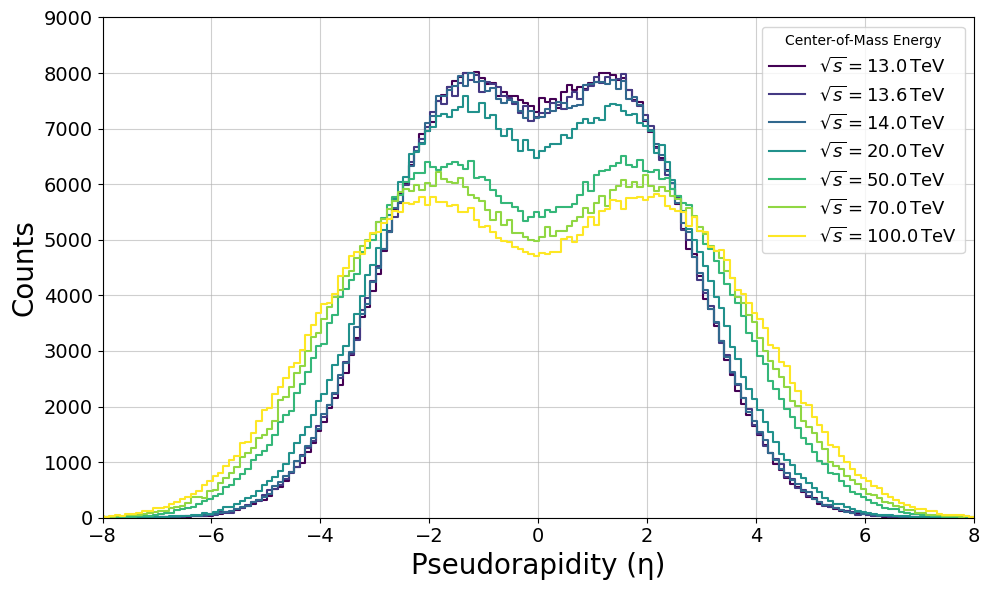

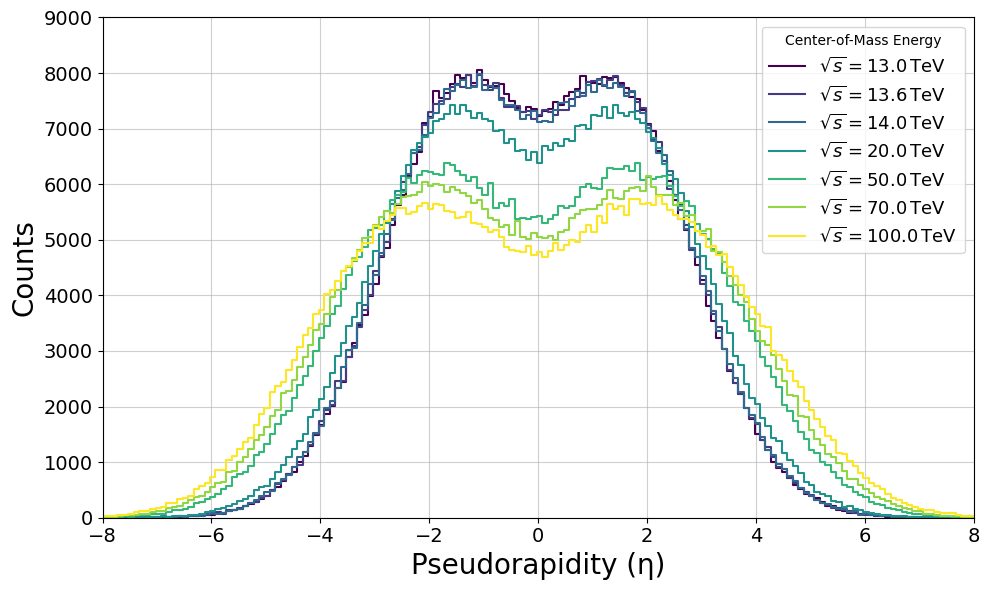

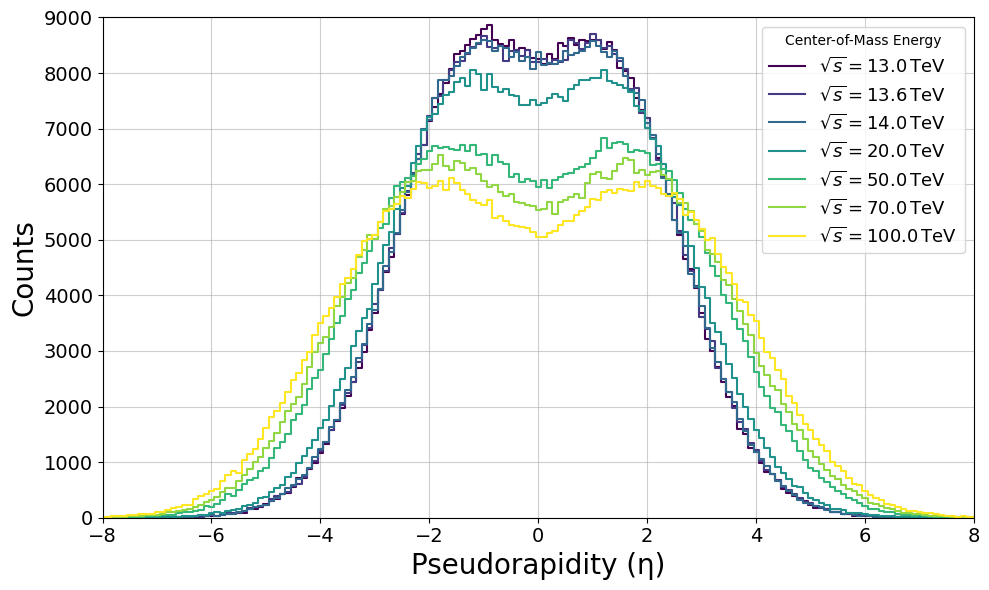

In [19]:
plot_eta_histograms_all_energies(data, "Z")
plot_eta_histograms_all_energies(data, "W+")
plot_eta_histograms_all_energies(data, "W-")

## Ploting Transverse momentum

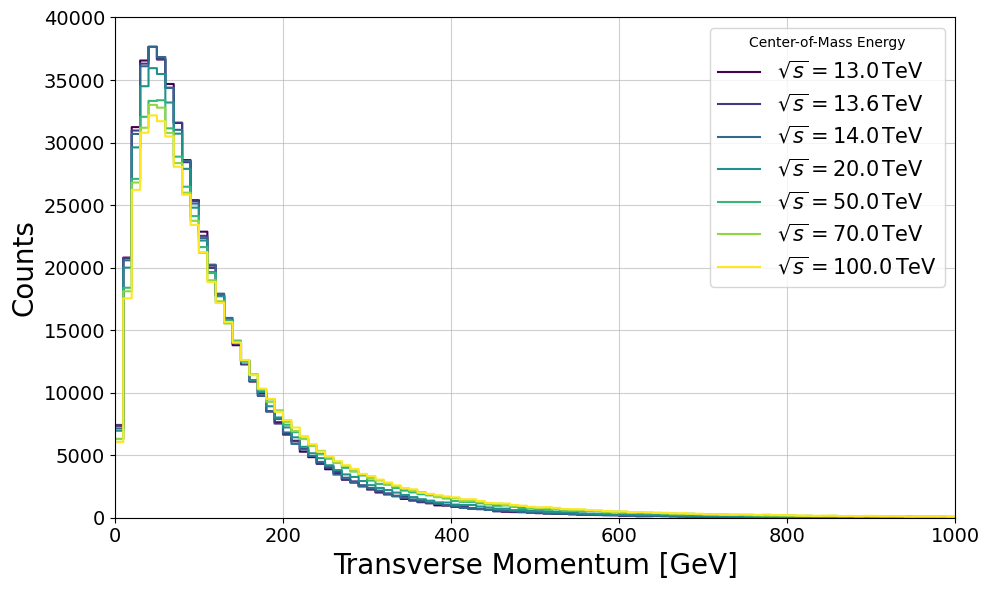

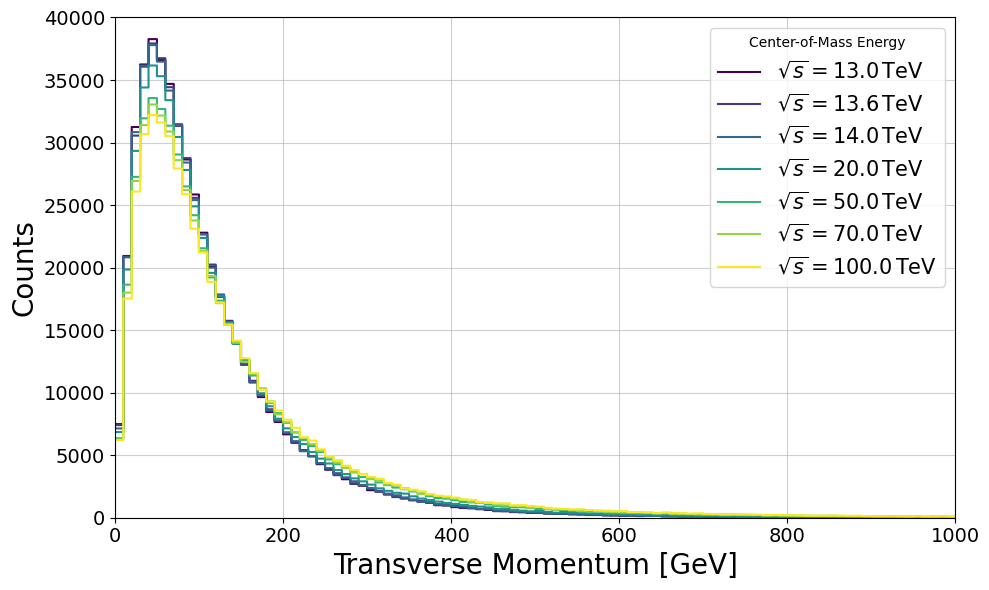

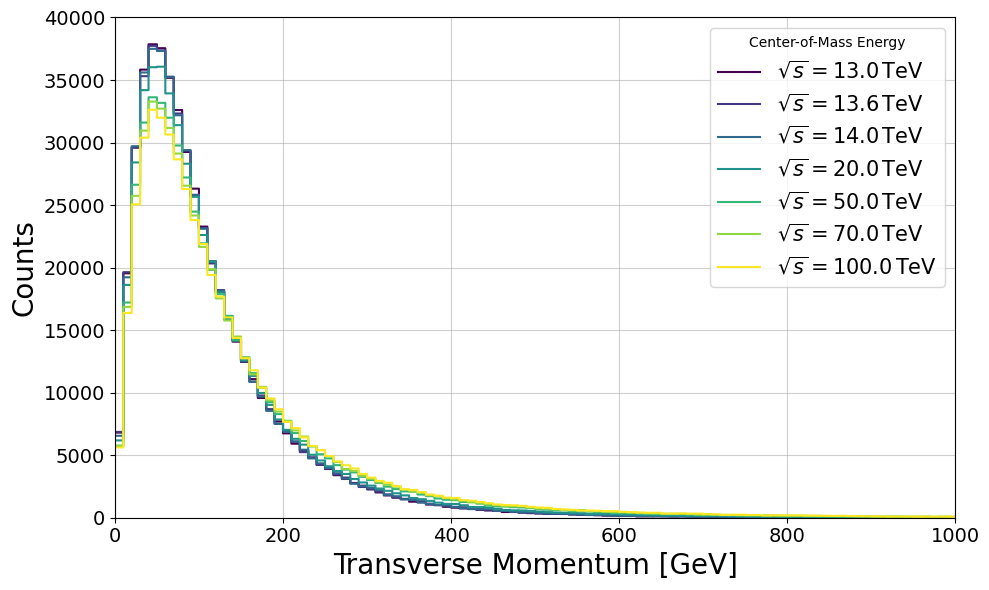

In [28]:
plot_pt_histograms_all_energies(data=data, boson_type="W-")

# Plot for W+ boson
plot_pt_histograms_all_energies(data=data, boson_type="W+")

# Plot for Z boson
plot_pt_histograms_all_energies(data=data, boson_type="Z")

## Plotting invariant mass distribution

plotted 13.0
plotted 13.6
plotted 14.0
plotted 20.0
plotted 50.0
plotted 70.0
plotted 100.0


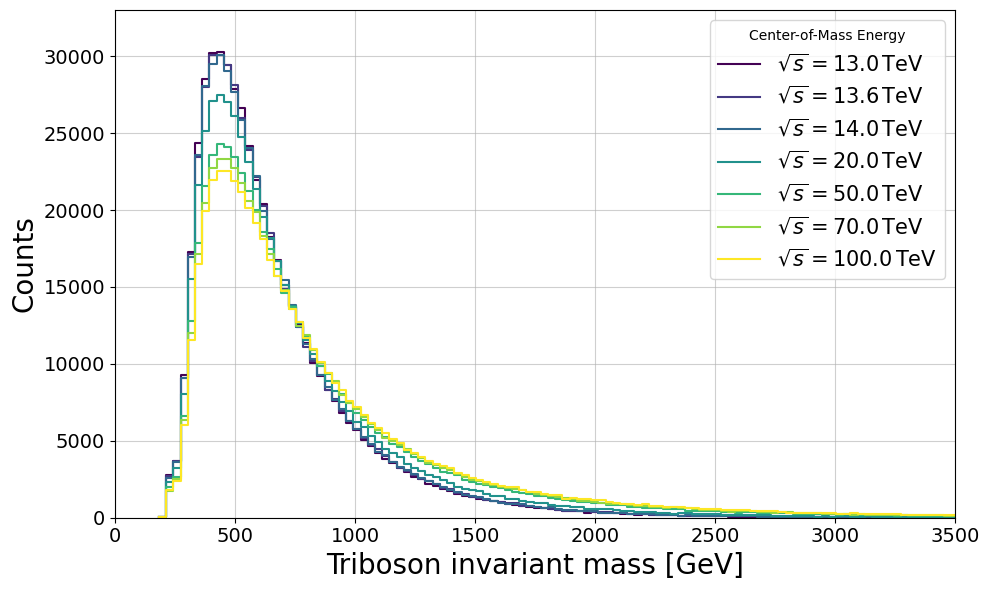

In [21]:
plot_partonic_inv_mass(data)

In [22]:
for i in ["13.0", "13.6", "14.0", "20.0", "50.0", "70.0", "100.0"]:
    inv = calculate_inv_mass(data, i)
    print(np.min(inv))

191.08135912038182
183.49330778642772
186.55284498623743
188.85632200889705
187.1082433176933
185.554453690113
192.35439291791045


## Plotting Helicity fractions 

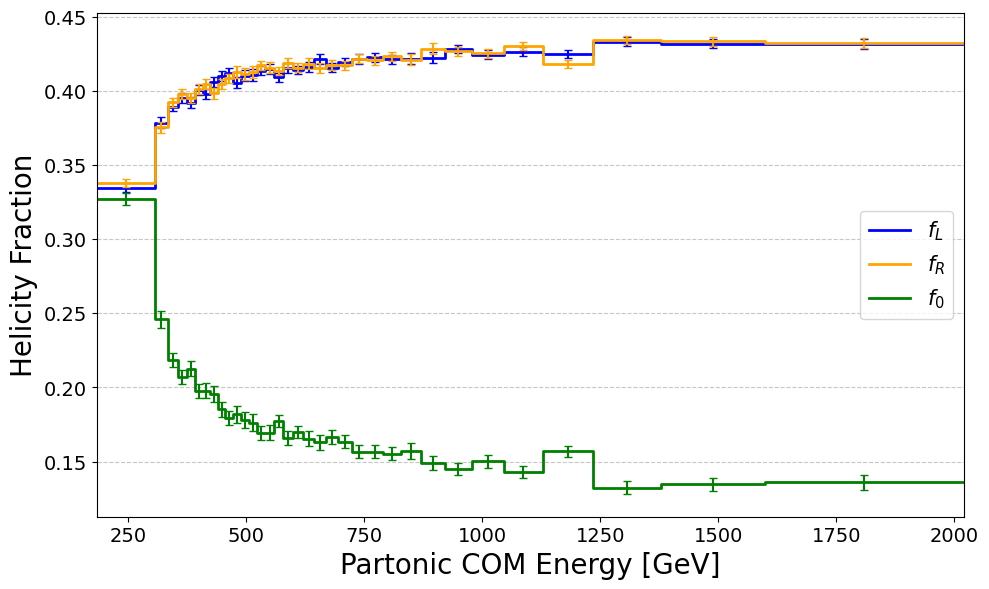

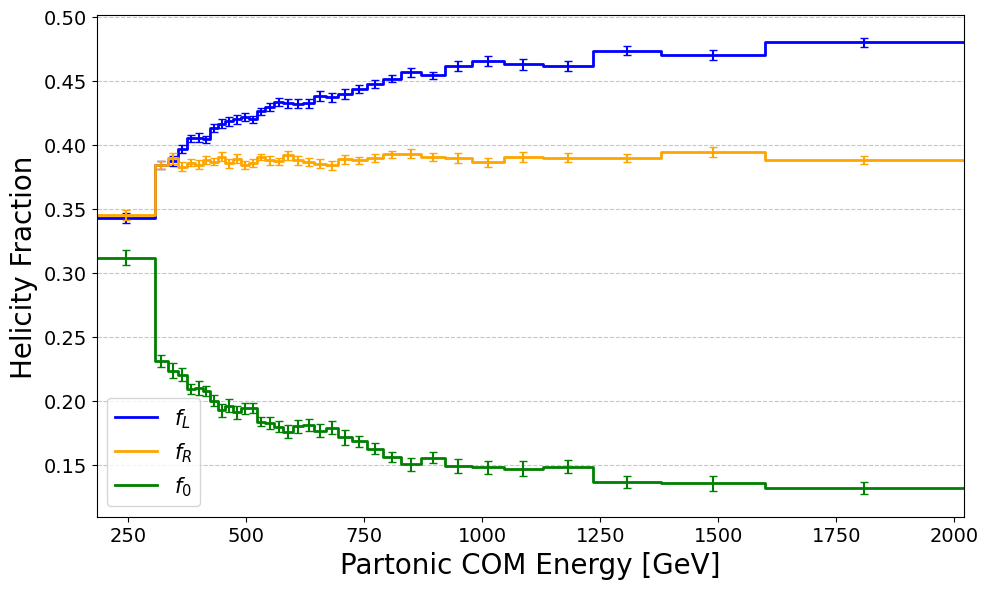

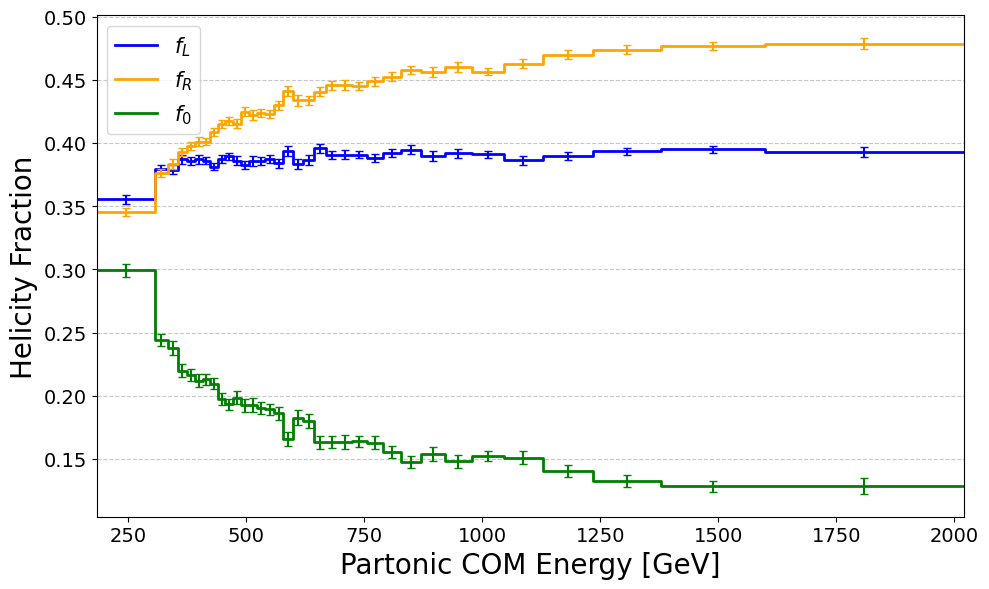

In [23]:
plot_helicity_fracs(data, "Z")
plot_helicity_fracs(data, "W+")
plot_helicity_fracs(data, "W-")

In [24]:
print(data["100.0"]["W+"]["Decay Angle"][0])
print(data["100.0"]["W-"]["Decay Angle"][0])
print(data["100.0"]["Z"]["Decay Angle"][0])

1.306085932895041
0.2813703152699745
1.531697973780917


## Helicity Fractions as a function of $\sqrt{s}$

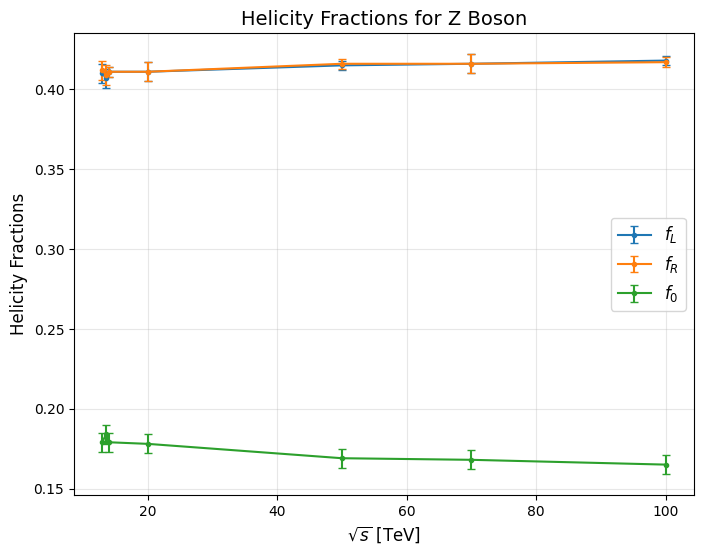

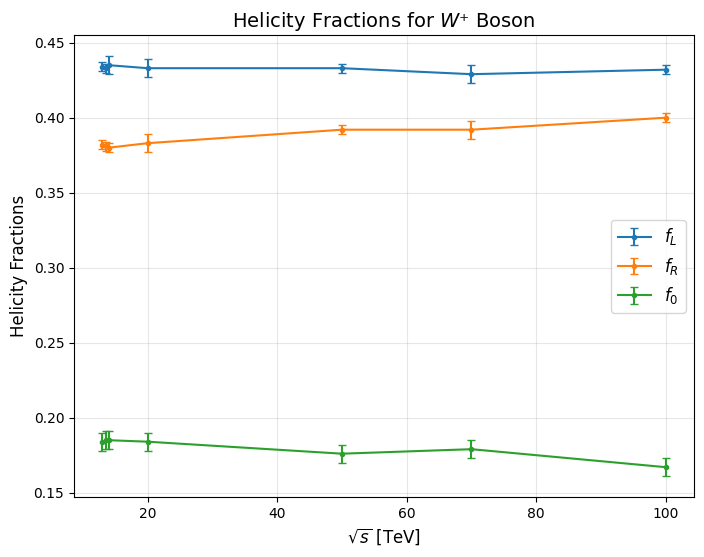

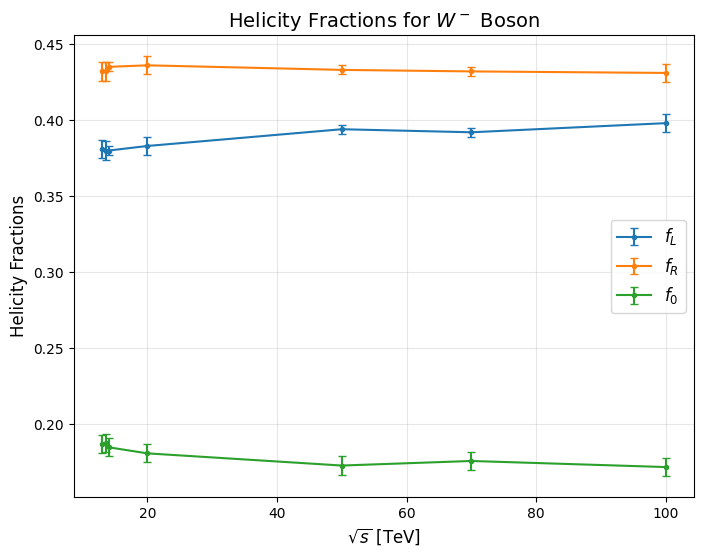

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Data: Helicity fractions for each boson at different energy levels
data_1 = np.array([
    [13, 0.410, 0.412, 0.179, 0.002, 0.002, 0.002],
    [13, 0.434, 0.382, 0.184, 0.001, 0.001, 0.002],
    [13, 0.381, 0.432, 0.187, 0.002, 0.002, 0.002],
    [13.6, 0.407, 0.409, 0.184, 0.002, 0.002, 0.002],
    [13.6, 0.433, 0.381, 0.185, 0.001, 0.001, 0.002],
    [13.6, 0.380, 0.432, 0.188, 0.002, 0.002, 0.002],
    [14, 0.411, 0.411, 0.179, 0.001, 0.001, 0.002],
    [14, 0.435, 0.380, 0.185, 0.002, 0.001, 0.002],
    [14, 0.380, 0.435, 0.185, 0.001, 0.001, 0.002],
    [20, 0.411, 0.411, 0.178, 0.002, 0.002, 0.002],
    [20, 0.433, 0.383, 0.184, 0.002, 0.002, 0.002],
    [20, 0.383, 0.436, 0.181, 0.002, 0.002, 0.002],
    [50, 0.415, 0.416, 0.169, 0.001, 0.001, 0.002],
    [50, 0.433, 0.392, 0.176, 0.001, 0.001, 0.002],
    [50, 0.394, 0.433, 0.173, 0.001, 0.001, 0.002],
    [70, 0.416, 0.416, 0.168, 0.002, 0.002, 0.002],
    [70, 0.429, 0.392, 0.179, 0.002, 0.002, 0.002],
    [70, 0.392, 0.432, 0.176, 0.001, 0.001, 0.002],
    [100, 0.418, 0.417, 0.165, 0.001, 0.001, 0.002],
    [100, 0.432, 0.400, 0.167, 0.001, 0.001, 0.002],
    [100, 0.398, 0.431, 0.172, 0.002, 0.002, 0.002]
])

def plot_helicity_fractions(data, boson_index, boson_label):
    """
    Plots the helicity fractions (f_L, f_R, f_0) for a given boson across energy levels.
    
    Parameters:
        data (np.ndarray): The helicity fraction data (7 columns).
        boson_index (int): Index of the boson (0, 1, or 2 for the 1st, 2nd, or 3rd boson).
        boson_label (str): Label for the boson (e.g., "W⁺", "Z").
    """
    # Filter data for the selected boson (every third row starting from boson_index)
    boson_data = data[boson_index::3]
    
    # Extract values
    sqrt_s = boson_data[:, 0]  # Energy levels
    f_L = boson_data[:, 1]
    f_R = boson_data[:, 2]
    f_0 = boson_data[:, 3]
    f_L_err = boson_data[:, 4]*3
    f_R_err = boson_data[:, 5]*3
    f_0_err = boson_data[:, 6]*3

    # Plot
    plt.figure(figsize=(8, 6))
    plt.errorbar(sqrt_s, f_L, yerr=f_L_err, fmt='.-', label="$f_L$", capsize=3)
    plt.errorbar(sqrt_s, f_R, yerr=f_R_err, fmt='.-', label="$f_R$", capsize=3)
    plt.errorbar(sqrt_s, f_0, yerr=f_0_err, fmt='.-', label="$f_0$", capsize=3)

    # Labels and legend
    plt.title(f"Helicity Fractions for {boson_label} Boson", fontsize=14)
    plt.xlabel(r"$\sqrt{s}$ [TeV]", fontsize=12)
    plt.ylabel("Helicity Fractions", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    plt.show()

# Example usage: Plot helicity fractions for the 1st boson ("W⁺")
plot_helicity_fractions(data_1, boson_index=0, boson_label="Z")
plot_helicity_fractions(data_1, boson_index=1, boson_label=r"$W⁺$")
plot_helicity_fractions(data_1, boson_index=2, boson_label=r"$W^-$")


In [26]:
f_L = data_1[:, 1]
f_R = data_1[:, 2]
f_0 = data_1[:, 3]

print(f_L  - f_R)

[-0.002  0.052 -0.051 -0.002  0.052 -0.052  0.     0.055 -0.055  0.
  0.05  -0.053 -0.001  0.041 -0.039  0.     0.037 -0.04   0.001  0.032
 -0.033]
